# 直方图4：直方图反投影

### 目标

在本章中，我们将学习直方图反投影。

### 理论

这是由**Michael J. Swain**和**Dana H. Ballard**在他们的论文《**通过颜色直方图索引**》中提出的。

**用简单的话说是什么意思**？它用于图像分割或在图像中查找感兴趣的对象。简而言之，它创建的图像大小与输入图像相同（但只有一个通道），其中每个像素对应于该像素属于我们物体的概率。用更简单的话来说，与其余部分相比，输出图像将在可能有对象的区域具有更多的白色值。好吧，这是一个直观的解释。（我无法使其更简单）。直方图反投影与camshift算法等配合使用。

**我们该怎么做呢**？我们创建一个图像的直方图，其中包含我们感兴趣的对象（在我们的示例中是背景，离开播放器等）。对象应尽可能填充图像以获得更好的效果。而且颜色直方图比灰度直方图更可取，因为对象的颜色对比灰度强度是定义对象的好方法。然后，我们将该直方图“反投影”到需要找到对象的测试图像上，换句话说，我们计算出属于背景的每个像素的概率并将其显示出来。在适当的阈值下产生的输出使我们仅获得背景。

### Numpy中的算法

1. 首先，我们需要计算我们要查找的对象（使其为“ M”）和要搜索的图像（使其为“ I”）的颜色直方图。

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

#roi是我们需要找到的对象或对象区域
roi = cv.imread('data/rose_red.png')
hsv = cv.cvtColor(roi,cv.COLOR_BGR2HSV)

#目标是我们搜索的图像
target = cv.imread('data/rose.png')
hsvt = cv.cvtColor(target,cv.COLOR_BGR2HSV)

# 使用calcHist查找直方图。也可以使用np.histogram2d完成
M = cv.calcHist([hsv],[0, 1], None, [180, 256], [0, 180, 0, 256] )
I = cv.calcHist([hsvt],[0, 1], None, [180, 256], [0, 180, 0, 256] )

2. 求出比值$R = \frac{M}{I}$。然后反向投影R，即使用R作为调色板，并以每个像素作为其对应的目标概率创建一个新图像。即`B(x,y) = R[h(x,y),s(x,y)]` 其中h是色调，s是像素在(x，y)的饱和度。之后，应用条件$B(x,y) = min[B(x,y), 1]$。

In [2]:
R = M / I
h,s,v = cv.split(hsvt)
B = R[h.ravel(),s.ravel()]
B = np.minimum(B,1)
B = B.reshape(hsvt.shape[:2])

C:\Users\zktr\AppData\Local\Temp\ipykernel_8420\2191126403.py:1: RuntimeWarning: invalid value encountered in divide
  R = M / I


3. 现在对圆盘应用卷积，$B = D \ast B$，其中D是圆盘内核。

In [3]:
disc = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
cv.filter2D(B,-1,disc,B)
B = np.uint8(B)
cv.normalize(B,B,0,255,cv.NORM_MINMAX)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

4. 现在最大强度的位置给了我们物体的位置。如果我们期望图像中有一个区域，则对合适的值进行阈值处理将获得不错的结果。

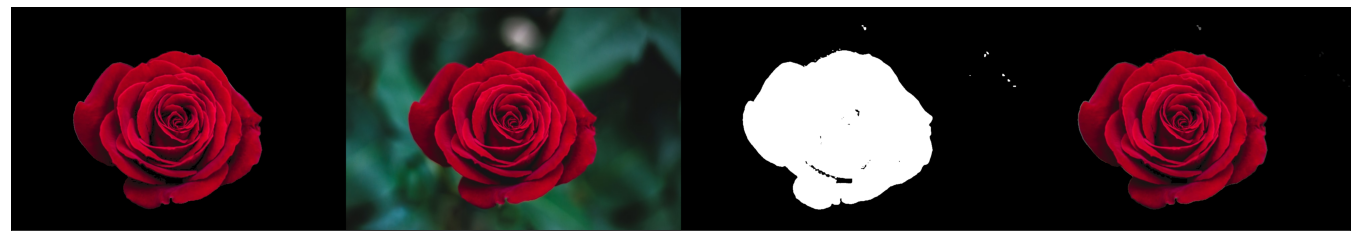

In [4]:
ret,thresh = cv.threshold(B,50,255,0) 

thresh = cv.merge((thresh,thresh,thresh))
res = cv.bitwise_and(target,thresh)
res = np.hstack((roi,target,thresh,res))

plt.figure(figsize=(24,6))
plt.imshow(cv.cvtColor(res,cv.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

就是这样！！

### OpenCV的反投影

OpenCV提供了一个内建的函数**cv.calcBackProject**()。它的参数几乎与**cv.calchist**()函数相同。它的一个参数是直方图，也就是物体的直方图，我们必须找到它。另外，在传递给backproject函数之前，应该对对象直方图进行归一化。它返回概率图像。然后我们用圆盘内核对图像进行卷积并应用阈值。下面是我的代码和结果:

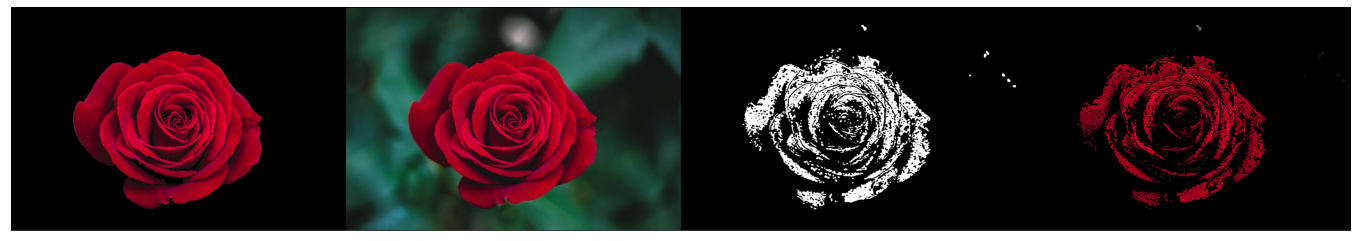

In [5]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

roi = cv.imread('data/rose_red.png')
hsv = cv.cvtColor(roi,cv.COLOR_BGR2HSV)

target = cv.imread('data/rose.png')
hsvt = cv.cvtColor(target,cv.COLOR_BGR2HSV)

# 计算对象的直方图
roihist = cv.calcHist([hsv],[0, 1], None, [180, 256], [0, 180, 0, 256] )

# 直方图归一化并利用反传算法
cv.normalize(roihist,roihist,0,255,cv.NORM_MINMAX)
dst = cv.calcBackProject([hsvt],[0,1],roihist,[0,180,0,256],1)

# 用圆盘进行卷积
disc = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
cv.filter2D(dst,-1,disc,dst)

# 应用阈值作与操作
ret,thresh = cv.threshold(dst,50,255,0)
thresh = cv.merge((thresh,thresh,thresh))

res = cv.bitwise_and(target,thresh)
res = np.hstack((roi,target,thresh,res))

plt.figure(figsize=(24,6))
plt.imshow(cv.cvtColor(res,cv.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

以下是一个示例。将蓝色矩形内的区域用作示例对象，提取整个地面。

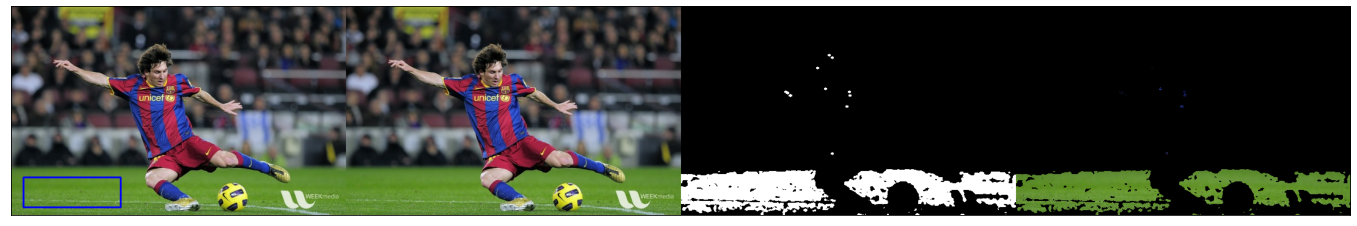

In [6]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

org = cv.imread('data/messi5.jpg')
img = org.copy()

grass = img[280:330, 20:180]
cv.rectangle(img, (20,280,160,50), (255, 0, 0), 2)
hsv = cv.cvtColor(grass,cv.COLOR_BGR2HSV)

target = org.copy()
hsvt = cv.cvtColor(target,cv.COLOR_BGR2HSV)

# 计算对象的直方图
roihist = cv.calcHist([hsv],[0, 1], None, [180, 256], [0, 180, 0, 256] )

# plt.figure(figsize=(12,6))
# plt.subplot(121)
# plt.imshow(cv.cvtColor(grass,cv.COLOR_BGR2RGB))
# plt.xticks([]), plt.yticks([])
# plt.subplot(122)
# plt.imshow(roihist, 'gray')
# plt.xticks([]), plt.yticks([])
# plt.show()

# 直方图归一化并利用反传算法
cv.normalize(roihist,roihist,0,255,cv.NORM_MINMAX)
dst = cv.calcBackProject([hsvt],[0,1],roihist,[0,180,0,256],1)

# 用圆盘进行卷积
disc = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
cv.filter2D(dst,-1,disc,dst)

# 应用阈值作与操作
ret,thresh = cv.threshold(dst,150,255,0)
thresh = cv.merge((thresh,thresh,thresh))

res = cv.bitwise_and(target,thresh)
res = np.hstack((img,target,thresh,res))

plt.figure(figsize=(24,6))
plt.imshow(cv.cvtColor(res,cv.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

### 附加资源

1. "Indexing via color histograms", Swain, Michael J. , Third international conference on computer vision,1990.

### 练习